In [139]:
import os
import numpy as np
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from analysis._utils import *
import yaml

In [158]:
def plot_trailing_loss_vs_parameter_legend(config_pardir, parameter, legend):
    configs = {}
    # go through all the config files and get the parameters and the loss
    for file_path in find_config_files(config_pardir):
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)
            parent_dir = os.path.dirname(file_path)
            if os.path.exists(os.path.join(parent_dir, "loss_curves.csv")):
                loss_df = pd.read_csv(os.path.join(parent_dir, "loss_curves.csv"), index_col=0)
                loss = loss_df["centered_test_losses"][loss_df["centered_test_losses"].idxmin()]
                configs[os.path.dirname(file_path)] = (loss, OmegaConf.create(data))
    print(sorted(configs.keys()))
    parameters = parameter.split(".")
    param_name = parameters[1]
    legends = legend.split(".")

    # get the trailing loss for each parameter value
    trailing_dict = {}
    global value
    for key, value in configs.items():
        legend_name = value[1][legends[0]][legends[1]]
        param_value = value[1][parameters[0]][parameters[1]]
        num_unique_worms = value[1]['globals']['num_unique_worms']
        # num_covered_neurons = value[1]['num_covered_neurons']
        loss = value[0] 
        print(f"{legend_name} {param_value} {loss}")
        if legend_name in trailing_dict.keys():
            trailing_dict[legend_name].update({param_value: loss})
        else:
            trailing_dict[legend_name] = {param_value: loss}
        # for different random seeds
        # if dataset_name in trailing_dict:
        #     if train_size in trailing_dict[dataset_name]:
        #         trailing_dict[dataset_name][train_size].append(loss)
        #     else:
        #         trailing_dict[dataset_name].update({train_size: [loss]})
        # else:
        #     trailing_dict[dataset_name] = {train_size: [loss]}
    print(sorted(trailing_dict.keys()))
    # plot the trailing loss for each parameter value
    # for i, (x, y) in enumerate(pairs):
    #     pairs = sorted(zip(dataset_dict.keys(), dataset_dict.values()))
    #     plt.plot(np.log10(x)*np.ones_like(y), y, color="g")
    for para_n, val_dict in trailing_dict.items():
        sorted_x, sorted_y = zip(*sorted(zip(list(val_dict.keys()), list(val_dict.values()))))
        plt.plot(np.log10(sorted_x), sorted_y, label=para_n, marker="o")

    plt.legend(loc="best")
    plt.xlabel("$log_{10}$ Training Size")
    plt.ylabel("Validation Loss")
    plt.title("Scaling plot: loss vs train size \n Validation loss after 1 training epoch on different datasets")
    plt.savefig("figures/scaling_plot_val_loss_vs_train_size.png")

['../logs/hydra/2023_04_14_10_58_11/0', '../logs/hydra/2023_04_14_10_58_11/1', '../logs/hydra/2023_04_14_10_58_11/10', '../logs/hydra/2023_04_14_10_58_11/11', '../logs/hydra/2023_04_14_10_58_11/12', '../logs/hydra/2023_04_14_10_58_11/13', '../logs/hydra/2023_04_14_10_58_11/14', '../logs/hydra/2023_04_14_10_58_11/15', '../logs/hydra/2023_04_14_10_58_11/16', '../logs/hydra/2023_04_14_10_58_11/17', '../logs/hydra/2023_04_14_10_58_11/18', '../logs/hydra/2023_04_14_10_58_11/19', '../logs/hydra/2023_04_14_10_58_11/2', '../logs/hydra/2023_04_14_10_58_11/20', '../logs/hydra/2023_04_14_10_58_11/21', '../logs/hydra/2023_04_14_10_58_11/22', '../logs/hydra/2023_04_14_10_58_11/23', '../logs/hydra/2023_04_14_10_58_11/24', '../logs/hydra/2023_04_14_10_58_11/25', '../logs/hydra/2023_04_14_10_58_11/26', '../logs/hydra/2023_04_14_10_58_11/27', '../logs/hydra/2023_04_14_10_58_11/28', '../logs/hydra/2023_04_14_10_58_11/29', '../logs/hydra/2023_04_14_10_58_11/3', '../logs/hydra/2023_04_14_10_58_11/30', '..

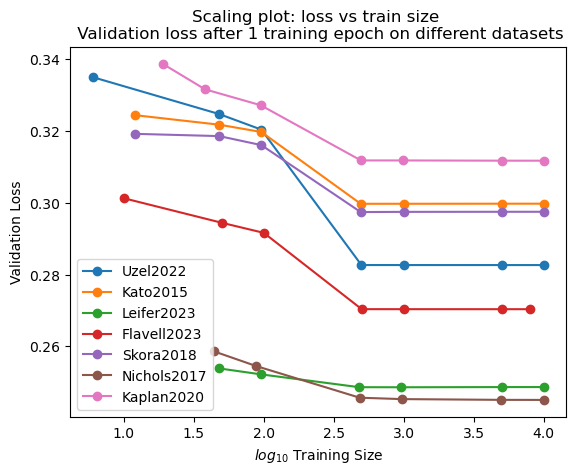

In [159]:
plot_trailing_loss_vs_parameter_legend("../logs/hydra", "train.train_size", "dataset.name")

In [148]:
value[1]['globals']['num_unique_worms']

6

In [149]:
value[1]['num_covered_neurons']

66